# Training the backbone model

## Imports

In [103]:
import torchvision.datasets
import os
import random as r
import torchvision.transforms
import torch.nn.functional as F
import torch
from torchsummary import summary
import torch.nn as nn
import tqdm
import PIL
from PIL import Image
import cv2
from PIL import ImageDraw
import matplotlib.pyplot as plt

## Loading the dataset

In [104]:
def dataset(path):
    return torchvision.datasets.ImageFolder(
        root=path)

In [13]:
path_buff = '/home/efficientnet/notebooks/af_data/africa_dataset/only_buff'
path_zebra = '/home/efficientnet/notebooks/af_data/africa_dataset/only_zebra'
path_rhino = '/home/efficientnet/notebooks/af_data/africa_dataset/only_rhino'
path_elephant = '/home/efficientnet/notebooks/af_data/africa_dataset/only_elephant'

In [14]:
path_buff_2 = path_buff + '/buffalo/'
path_zebra_2 = path_zebra + '/zebra/'
path_rhino_2 = path_rhino + '/rhino/'
path_elephant_2 = path_elephant + '/elephant/'

In [15]:
def get_detection_dataset(path):
    liste_fichiers = os.listdir(path)
    n_max = max([int(nom[:3]) for nom in liste_fichiers])
    res = []
    for i in range(1, 1+n_max):
        if i<10:
            name_base = '00'+str(i)
        elif i<100:
            name_base = '0'+str(i)
        else:
            name_base = str(i)
            
        if not((name_base+'.jpg' in liste_fichiers and name_base+'.txt' in liste_fichiers)):
            continue 
        else:
            name_im_file = name_base+'.jpg'
            name_txt_file = name_base+'.txt'
            im = Image.open(path + name_im_file)
            rects = []
            with open(path+name_txt_file, "r") as file:
                for line in file.readlines():
                    l = line.split(' ')
                    coords = float(l[1]), float(l[2]), float(l[3]), float(l[4].strip())
                    label = int(l[0])
                    rects.append((label, coords))
        res.append((im, rects))
    return res

In [16]:
det_dataset =get_detection_dataset(path_buff_2) +get_detection_dataset(path_zebra_2)+get_detection_dataset(path_rhino_2)+get_detection_dataset(path_elephant_2)

## Dataset preparation

In [18]:
def interpolate(img, res):
    if img.ndim ==4:
        img_perm = F.interpolate(img, size = res)
        img_perm = img_perm.permute(0,1,3,2)
        img_perm = F.interpolate(img_perm, size =res)
        img_perm = img_perm.permute(0,1,3,2)
        return img_perm
    elif img.ndim==3:
        img_perm = F.interpolate(img, size = res)
        img_perm = img_perm.permute(0,2,1)
        img_perm = F.interpolate(img_perm, size =res)
        img_perm = img_perm.permute(0,2,1)
        return img_perm
    else:
        raise Exception("tensor dimension should be 3 or 4")
    

In [19]:
det_dataset = r.sample(det_dataset, len(det_dataset))

In [20]:
t = torchvision.transforms.ToTensor()
det_data_t = [(interpolate(t(image),140), label) for (image, label) in det_dataset]

In [38]:
def crop_tensor(image,region):
    x,y,w_r,h_r = region
    _,w,h = image.size()
    x_abs ,y_abs = w*x ,h*y
    y_top = y_abs - h_r*h/2
    x_left = x_abs - w_r*w/2
    return image[:, int(y_top):int(y_top+h_r*h),int(x_left):int(x_left+w_r*w)]

In [39]:
def get_clf_dataset(det_dataset):
    res = []
    # tuple image (croppée), label
    for im, list_lab_rec in det_dataset:
        for label, rectangle in list_lab_rec:
            crop_im = crop_tensor(im, rectangle)
            res.append((crop_im, label))
    return res

In [41]:
clf_dataset = get_clf_dataset(det_data_t)

In [49]:
dict_labels = {0:'buffalo', 1 : "elephant", 2: "rhino", 3 : "zebra", 4:"background"}

In [59]:
def transform(data):
    tf = torchvision.transforms.Compose([torchvision.transforms.ToPILImage(),
    torchvision.transforms.ColorJitter(hue=.03, saturation=.03),
    torchvision.transforms.RandomHorizontalFlip(),
    torchvision.transforms.RandomRotation(10, resample=PIL.Image.BILINEAR), 
                                        torchvision.transforms.ToTensor()])
    trans_data = [(tf(image), label) for (image, label) in data]
    return trans_data
    

## Data augmentation

In [60]:
def augment(data, n):
    res = []
    for _ in range(n):
        res =res+ transform(data)
    return res

In [94]:
data_aug = augment(clf_dataset, 6)
data_tens = [(interpolate(image,140), label) for (image, label) in data_aug]
shuf_ds =  r.sample(data_tens, len(data_tens))

In [98]:
prop_train =.8
n = len(shuf_ds)
n_train = int(n*prop_train)

trainset = shuf_ds[:n_train]
testset = shuf_ds[n_train:]

In [99]:
len(testset)

3219

## Training functions

In [100]:
from python_files.get_data import *
from python_files.resnetclass import *

import tqdm
import matplotlib.pyplot as plt
import time as t

# Redéfinition des éléments de gs et train

def accuracy(net,testset,num_points = len(testset),batch_size = 64,cuda=True):
    r=net.resolution
    testloader = get_loader(testset, batch_size, num_points=num_points)
    ## les images sont sous formes de dataloader de tenseurs d'une certaine taille
    net.eval()
    correct = 0
    total = 0
    if cuda:
        net.to('cuda')
    with torch.no_grad():
        for data in testloader:
            images, labels = data
            images2 = interpolate(images,r) 
            if cuda:
                images2= images2.to('cuda')
                labels = labels.to('cuda')
            ## dans tous les cas ici il faut changer la resol de l'image 
            outputs = net(images2)
            _, predicted = torch.max(outputs.data, 1)
           
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        return 100.0 * correct/total

def train(model, optimizer, trainset, loss_fn,num_points=5000, batch_size=220,  n_epoch = 40, cuda=True,disp=True):
    if cuda:
        model.to('cuda')
    resol_cible = model.resolution
    trainloader = get_loader(trainset, batch_size, num_points=num_points)
    loss_func = loss_fn()
    if disp==True:
        for i in tqdm.notebook.tqdm(range(n_epoch)):
            #print('epoch', 1+i, '/', n_epoch)
            for data in trainloader:
                inputs, labels = data
                inputs2 = interpolate(inputs, resol_cible)
                if cuda:
                    inputs2 = inputs2.to('cuda') 
                    labels = labels.to('cuda')
                optimizer.zero_grad()
                outputs = model(inputs2)
                loss = loss_func(outputs, labels)
                loss.backward()
                optimizer.step()
        return model
    elif disp==False:
        for i in range(n_epoch):
            #print('epoch', 1+i, '/', n_epoch)
            for data in trainloader:
                inputs, labels = data
                inputs2 = interpolate(inputs, resol_cible)
                if cuda:
                    inputs2 = inputs2.to('cuda') 
                    labels = labels.to('cuda')
                optimizer.zero_grad()
                outputs = model(inputs2)
                loss = loss_func(outputs, labels)
                loss.backward()
                optimizer.step()
        return model
        

def train_acc_once(trainset, testset,num_points=5000, batch_size=220,width=16,resolution = 110, depth = [2,2,2,2],n_epoch=30, cuda=True,disp=True):
    model = get_resnet(depth = depth, resolution=resolution, width=width)
    model=model.to('cuda')
    optimizer = torch.optim.Adam(model.parameters())
    loss_fn = torch.nn.CrossEntropyLoss
    model = train(model, optimizer, trainset, loss_fn, num_points=num_points, batch_size=batch_size, n_epoch=n_epoch, cuda=cuda,disp=disp)
    acc = accuracy(model, testset, batch_size=batch_size)
    del model
    return acc

def train_acc_crossval(trainset, testset,num_points=5000, batch_size=220,width=16,resolution = 110, depth = [2,2,2,2],n_epoch=30, cuda=True,k=30,disp=True):
    accu_tot = 0
    for i in range(k):
        i+=1
        #print('validation',i,'/',k)
        acc = train_acc_once(trainset, testset, num_points=num_points, batch_size=batch_size, width=width, resolution=resolution, depth = depth, n_epoch=n_epoch, cuda = cuda,disp=disp)
        accu_tot+=acc
        print('accu obtenue:', acc)
    return accu_tot/k


def train_acc_multiple(trainset, testset,num_points=5000, batch_size=220,width=16,resolution = 110, depth = [2,2,2,2],n_epoch=30, cuda=True,k=30):
    list_acc = []
    for i in range(k):
        i+=1
        print('training',i,'/',k)
        acc = train_acc_once(trainset, testset, num_points=num_points, batch_size=batch_size, width=width, resolution=resolution, depth = depth, n_epoch=n_epoch, cuda = cuda)
        list_acc.append(acc)
        print('accu obtenue:', acc)
    return list_acc


def get_new_depth(alpha, depth):
    sd = sum(depth)
    i=0
    new_depth = depth.copy()
    while(sum(new_depth)<alpha*sd):
        new_depth[i%len(depth)] +=1
        i+=1
    return new_depth

## Training the model

In [105]:
resnet = get_resnet(width = 17, resolution=140,depth=[3,3,2,2], num_classes = 4)
resnet = resnet.to('cuda')
optimizer = torch.optim.Adam(resnet.parameters())
loss_fn = torch.nn.CrossEntropyLoss

In [109]:
len(trainset)

12873

In [110]:
resnet = train(resnet, optimizer, trainset, loss_fn, num_points = len(trainset), n_epoch = 250, cuda = True)

In [111]:
accuracy(resnet,testset, num_points = len(testset))

82.88288288288288

In [141]:
accuracy(resnet,trainset, num_points = len(testset))

84.93320907114011

In [203]:
path = '/home/efficientnet/notebooks/notebooks/models/resnetaf4.txt'

In [204]:
torch.save(resnet.state_dict(),path )

## Visualizing some results

In [181]:
def visualize_res(n):
    im, lab = testset[n]
    print('true label', dict_labels[lab])
    plt.imshow(im.permute(1,2,0))
    output = resnet(interpolate(im, 140).resize(1,3,140,140).to('cuda'))
    _, predicted = torch.max(output.data, 1)
    print('prediction : ', dict_labels[int(predicted)])

vrai label buffalo
prediction :  elephant


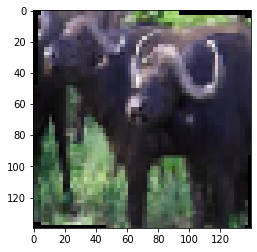

In [154]:
visualize_res(495)

## Classification stats

In [155]:
def get_stats():
    vrais = [0,0,0,0]
    faux = [0,0,0,0]
    tots = [0,0,0,0]
    for n in range(len(testset)):
        im, lab = testset[n]
        tots[lab]+=1
        output = resnet(interpolate(im, 140).resize(1,3,140,140).to('cuda'))
        _, predicted = torch.max(output.data, 1)
        lb =int(predicted)
        if lb==lab:
            vrais[lb]+=1
        else:
            faux[lb]+=1
    return vrais, faux, tots

In [156]:
get_stats()

([395, 847, 430, 996], [21, 432, 47, 51], [644, 872, 680, 1023])

In [157]:
295/644

0.4580745341614907

In [158]:
847/872

0.9713302752293578

In [159]:
430/680

0.6323529411764706

In [160]:
996/1023

0.9736070381231672

## Resampling for balanced classes

In [175]:
def get_proportions(trainset):
    cls = [0,0,0,0]
    for im, lbl in trainset:
        cls[int(lbl)]+=1
    a,b,c,d = cls 
    tot = sum(cls)
    a/=tot
    b/=tot
    c/=tot
    d/=tot
    return([a,b,c,d])

In [163]:
def divide(trainset):
    res = [[], [], [], []]
    for im, lbl in trainset:
        res[int(lbl)].append((im,lbl))
    return res

In [165]:
classes = divide(trainset)

In [171]:
def get_balanced_dataset(classes):
    res = []
    m = min([len(c) for c in classes] )
    for k in range(m):
        res.append((classes[0][k]))
        res.append((classes[1][k]))
        res.append((classes[2][k]))
        res.append((classes[3][k]))
    return res

In [172]:
bds = get_balanced_dataset(classes)

In [176]:
get_proportions(bds) 

[0.25, 0.25, 0.25, 0.25]

## Training on the balanced set

In [177]:
resnet = get_resnet(width = 17, resolution=140,depth=[3,3,2,2], num_classes = 4)
resnet = resnet.to('cuda')
optimizer = torch.optim.Adam(resnet.parameters())
loss_fn = torch.nn.CrossEntropyLoss

In [178]:
resnet = train(resnet, optimizer, bds, loss_fn, num_points = len(bds), n_epoch = 250, cuda = True)

In [205]:
accuracy(resnet, testset, len(testset))

98.81950916433675

In [206]:
path = '/home/efficientnet/notebooks/notebooks/models/resnetaf5.txt'
torch.save(resnet.state_dict(),path )

In [180]:
get_stats()

([634, 862, 669, 1016], [10, 19, 6, 3], [644, 872, 680, 1023])

## Showing some results

In [197]:
def disp_wrong(model, testset, n=10):
    for img,lbl in testset:
        output = resnet(interpolate(img, 140).resize(1,3,140,140).to('cuda'))
        _, predicted = torch.max(output.data, 1)
        lb =int(predicted)
        n=0
        if lb!=lbl:
            n+=1
            print("true label : ", dict_labels[lbl]," - predicted :", dict_labels[lb])
            #print("predicted :", dict_labels[lb])
            plt.imshow(img.permute(1,2,0))
            plt.show()
            if n==10:
                return
        

true label :  rhino  - predicted : elephant


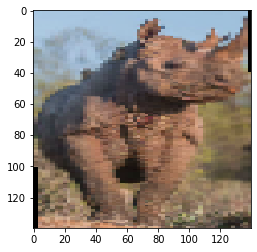

true label :  zebra  - predicted : elephant


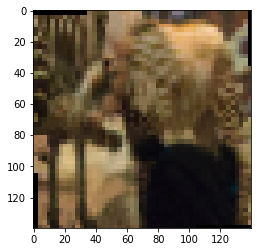

true label :  buffalo  - predicted : elephant


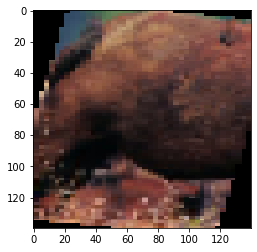

true label :  elephant  - predicted : buffalo


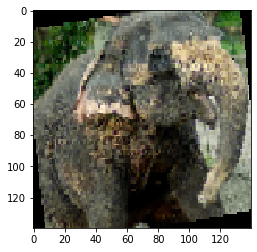

true label :  zebra  - predicted : buffalo


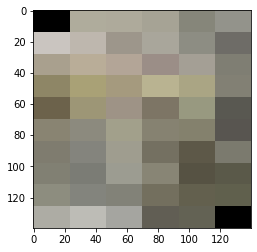

true label :  elephant  - predicted : buffalo


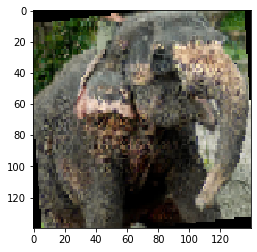

true label :  elephant  - predicted : buffalo


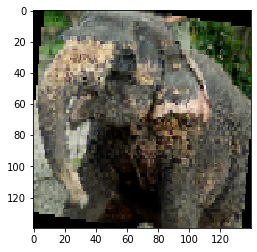

true label :  rhino  - predicted : elephant


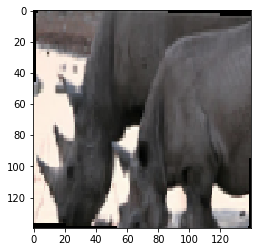

true label :  rhino  - predicted : zebra


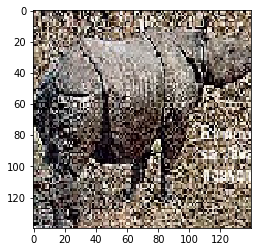

true label :  buffalo  - predicted : elephant


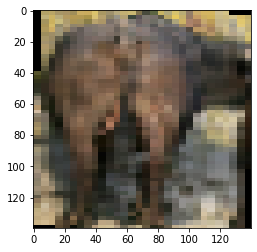

true label :  rhino  - predicted : elephant


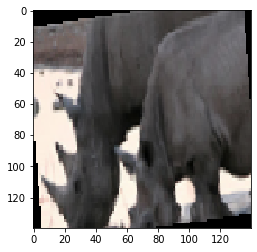

true label :  buffalo  - predicted : elephant


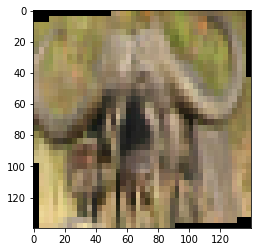

true label :  buffalo  - predicted : elephant


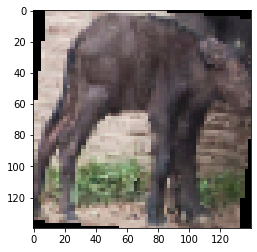

true label :  rhino  - predicted : buffalo


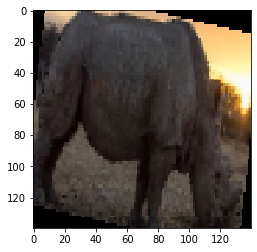

true label :  zebra  - predicted : elephant


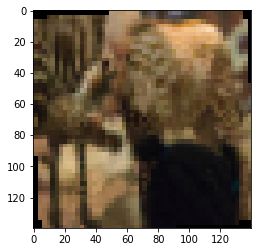

true label :  rhino  - predicted : elephant


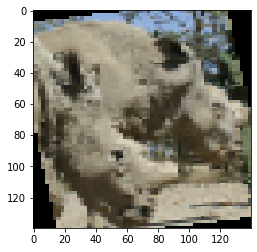

true label :  buffalo  - predicted : elephant


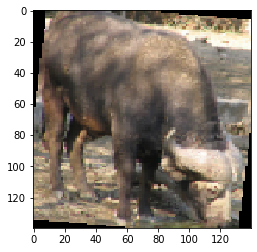

true label :  rhino  - predicted : elephant


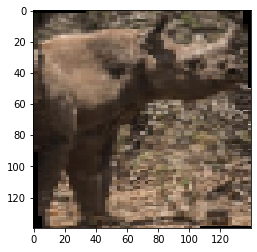

true label :  buffalo  - predicted : rhino


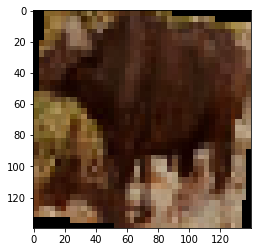

true label :  rhino  - predicted : elephant


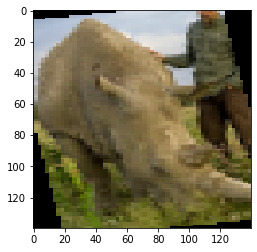

true label :  elephant  - predicted : buffalo


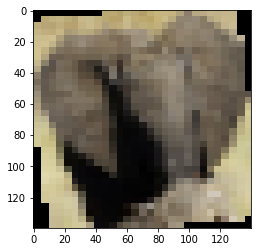

true label :  zebra  - predicted : rhino


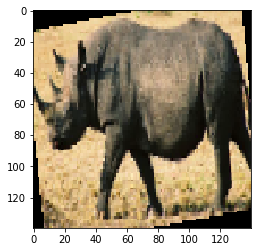

true label :  rhino  - predicted : buffalo


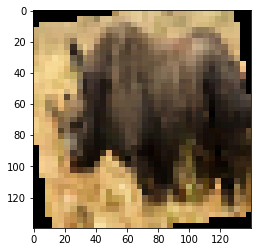

true label :  buffalo  - predicted : elephant


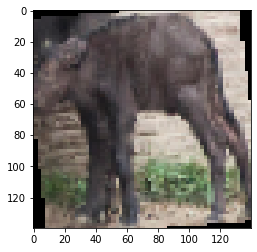

true label :  zebra  - predicted : elephant


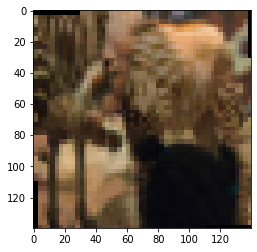

true label :  elephant  - predicted : zebra


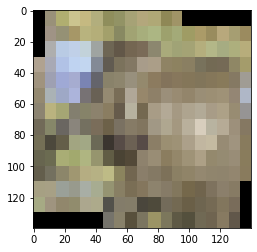

true label :  rhino  - predicted : buffalo


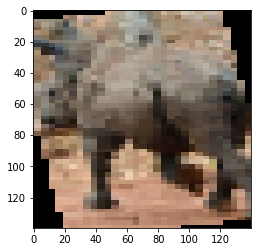

true label :  elephant  - predicted : buffalo


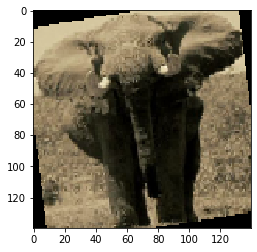

true label :  elephant  - predicted : zebra


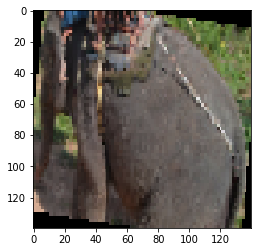

true label :  buffalo  - predicted : elephant


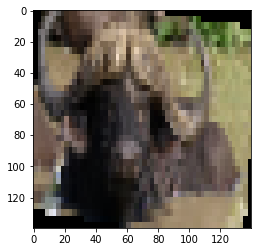

true label :  elephant  - predicted : buffalo


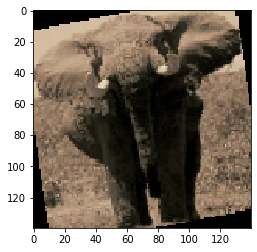

true label :  zebra  - predicted : rhino


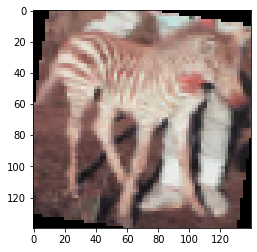

true label :  zebra  - predicted : elephant


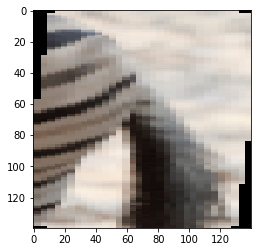

true label :  rhino  - predicted : elephant


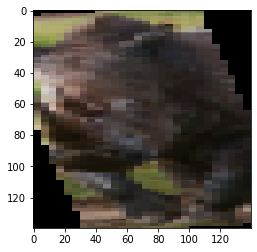

true label :  elephant  - predicted : rhino


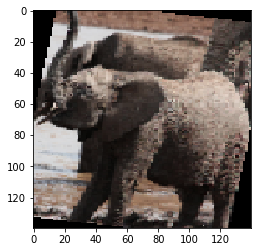

true label :  buffalo  - predicted : elephant


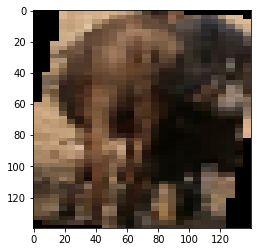

true label :  elephant  - predicted : rhino


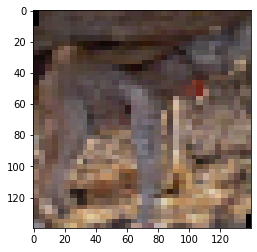

true label :  buffalo  - predicted : rhino


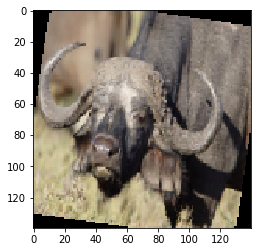

In [198]:
disp_wrong(resnet, testset)